In [4]:
import librosa
import numpy as np
import math
import scipy
import librosa.display
import librosa.decompose
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Audio

In [5]:
d = {}

pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\min6dB\pump\id_04\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\min6dB\pump\id_04\abnormal\00000000.wav'    
d['pump'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\fan\id_00\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\fan\id_00\abnormal\00000000.wav'    
d['fan'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\slider\id_02\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\slider\id_02\abnormal\00000000.wav'    
d['slider'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}
pn = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\valve\id_06\normal\00000000.wav'
pa = r'A:\Dev\NF_Prj_MIMII_Dataset\dataset\6dB\valve\id_06\abnormal\00000000.wav'    
d['valve'] = {'n': librosa.load(pn, sr=None, mono=False),
             'a': librosa.load(pa, sr=None, mono=False)}

sr = d['pump']['n'][1]

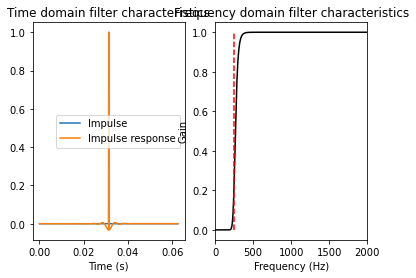

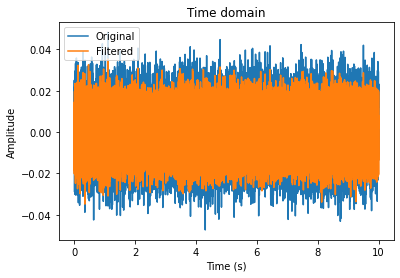

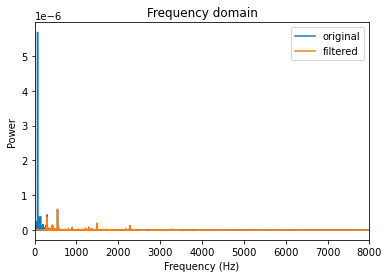

In [20]:
from scipy import signal

data = d['pump']['n'][0][0]
N = len(data)
time = np.linspace(0,N/sr,N)

fs = sr
filtcut = 250
filtb,filta = signal.butter(7,filtcut/(fs/2),btype='high')
# test impulse response function (IRF)
impulse  = np.zeros(1001)
impulse[501] = 1
fimpulse = signal.filtfilt(filtb,filta,impulse)
imptime  = np.arange(0,len(impulse))/fs


# plot impulse and IRF
plt.subplot(121)
plt.plot(imptime,impulse,label='Impulse')
plt.plot(imptime,fimpulse/np.max(fimpulse),label='Impulse response')
plt.xlabel('Time (s)')
plt.legend()
plt.title('Time domain filter characteristics')


# plot spectrum of IRF
plt.subplot(122)
hz = np.linspace(0,fs/2,3000)
imppow = np.abs(scipy.fftpack.fft(fimpulse,2*len(hz)))**2
plt.plot(hz,imppow[:len(hz)],'k')
plt.plot([filtcut,filtcut],[0,1],'r--')
plt.xlim([0,2000])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency domain filter characteristics')
plt.show()

# now filter the data and compare against the original
fdata = signal.filtfilt(filtb,filta,data)
plt.plot(time,data,label='Original')
plt.plot(time,fdata,label='Filtered')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time domain')
plt.show()


### power spectra of original and filtered signal
signalX = np.abs(scipy.fftpack.fft(data)/N)**2
fdataX  = np.abs(scipy.fftpack.fft(fdata)/N)**2
hz = np.linspace(0,fs,N)

plt.plot(hz,signalX[:len(hz)],label='original')
plt.plot(hz,fdataX[:len(hz)],label='filtered')
plt.xlim([0,sr/2])
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Frequency domain')
plt.show()

display(Audio(data=data,rate=sr))
display(Audio(data=fdata,rate=sr))

In [22]:
def fft_freq_axis_hz(pnts,srate):
    return np.linspace(0,srate/2,num=math.floor(pnts/2.)+1)

def fft_amp_scaled_abs(fCoefs,fpos_range=[]):
    if type(fpos_range) is np.ndarray:
        fpos_range = len(fpos_range)
    else:
        if not fpos_range:
            fpos_range = len(fCoefs)
    
    return 2*np.abs(fCoefs)[0:fpos_range] / len(fCoefs)

def fft_amp2power_abs(amps):
    return amps*amps;

def fft_phase(fCoefs, fpos_range=[]):
    if type(fpos_range) is np.ndarray:
        fpos_range = len(fpos_range)
    else:
        if not fpos_range:
            fpos_range = len(fCoefs)
            
    return np.angle(fCoefs)[0:fpos_range]

def phase_read2deg(p):
     return p*(180/np.pi)

def fft_complete(signal,srate):
    pnts = len(signal)
    fCoefs = np.fft.fft(signal) 
    hz = fft_freq_axis_hz(pnts,srate)
    amp = fft_amp_scaled_abs(fCoefs,hz)
    pwr = fft_amp2power_abs(amp)
    ph = fft_phase(fCoefs, hz)
    ph_deg = phase_read2deg(ph)
    return fCoefs,hz,amp,pwr,ph,ph_deg

def P2R(radii, angles):
    return radii * exp(1j*angles)

def R2P(x):
    return abs(x), angle(x)

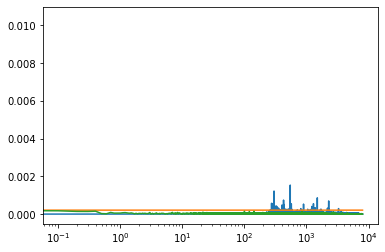

In [29]:
y = fdata
fCoefs,hz,amp,pwr,ph,ph_deg = fft_complete(y,sr)
plt.plot(hz,amp)
limit = np.mean(amp)+np.std(amp)*12
plt.plot(hz,np.ones(len(amp))* np.mean(amp)+np.std(amp)*6)
#plt.plot(hz,np.ones(len(amp))* np.mean(amp[np.where(hz<1000)]))
limit1k = np.mean(amp[np.where(hz<1000)])*4
fCoefsDenoise =  fCoefs
fCoefsDenoise[np.where(amp<limit)]=0
#fCoefsDenoise[np.where(np.logical_and(hz<1000,amp<limit1k))] = 0
denoised = np.fft.ifft(fCoefsDenoise)
display(Audio(data=y,rate=sr))
display(Audio(data=np.abs(denoised),rate=sr))
fCoefsde,hz,amp,pwr,ph,ph_deg = fft_complete(np.abs(denoised),sr)
plt.plot(hz,amp)
plt.xscale('log')